# Cargamos Librerías

In [1]:
import pandas as pd
import openpyxl
import warnings
import os
import matplotlib.pyplot as plt 
import seaborn as sns
import utils as eda

def warn(*args, **kwargs):
    pass
warnings.warn = warn
warnings.filterwarnings("ignore", category=FutureWarning)

# Cargamos los Dataset

In [2]:
movies = pd.read_csv("../data/interim/movies-data/ml-32m/movies.csv")
tags = pd.read_csv("../data/interim/movies-data/ml-32m/tags.csv")
ratings = pd.read_csv("../data/interim/movies-data/ml-32m/ratings.csv")

In [3]:
eda.analisis(movies)

Variables numéricas: ['movieId']
Variables no numéricas: ['title', 'genres']

Shape del dataset: (87585, 3)

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87585 entries, 0 to 87584
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  87585 non-null  int64 
 1   title    87585 non-null  object
 2   genres   87585 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.0+ MB
None

Valores nulos por columna:
movieId    0
title      0
genres     0
dtype: int64

Filas duplicadas:
Empty DataFrame
Columns: [movieId, title, genres]
Index: []


El dataset de películas, *movies*, contiene 3 variables: una variable numérica y dos variables categóricas. Hay 87585 instancias, sin valores nulos.

In [4]:
eda.analisis(tags)

Variables numéricas: ['userId', 'movieId', 'timestamp']
Variables no numéricas: ['tag']

Shape del dataset: (2000072, 4)

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000072 entries, 0 to 2000071
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   userId     int64 
 1   movieId    int64 
 2   tag        object
 3   timestamp  int64 
dtypes: int64(3), object(1)
memory usage: 61.0+ MB
None

Valores nulos por columna:
tag          17
userId        0
movieId       0
timestamp     0
dtype: int64

Filas duplicadas:
Empty DataFrame
Columns: [userId, movieId, tag, timestamp]
Index: []


El dataset de etiquetas, *tags*, contiene 4 variables: tres variables numéricas y una variable categórica. Hay 2000072, con 17 valores nulos en la columna *tag*.

## Análisis Exploratorio de Datos

### Eliminar Duplicados

Verificamos, para ambos datasets, si existen duplicados usando el *movieId* como clave.

In [5]:
movies.drop_duplicates()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
87580,292731,The Monroy Affaire (2022),Drama
87581,292737,Shelter in Solitude (2023),Comedy|Drama
87582,292753,Orca (2023),Drama
87583,292755,The Angry Breed (1968),Drama


No hay filas duplicadas en el dataset *movies*.

### Crear Lista de Géneros

Para poder hacer un mejor análisis de los datos, separaremos los géneros en una lista y transformaremos el registro, para que cada movieId tenga un género por fila.

In [6]:
movies["genres"] = movies["genres"].str.split("|")

movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


In [7]:
movie_genre = movies.explode("genres").reset_index(drop=True)
movie_genre.drop("title", axis=1, inplace=True)
movie_genre.head()

,movieId,genres
0,1,Adventure
1,1,Animation
2,1,Children
3,1,Comedy
4,1,Fantasy


Eliminar las filas duplicadas del dataset *tags* requiere otras consideraciones, pues al tratarse de un dataset creado por los usuarios que han visto la película, pueden existir duplicados. Esto lo vemos, por ejemplo, en la película Pulp Fiction, que tiene 6697 etiquetas. Ya que las etiquetas están relacionadas con el momento de la película (*timestamp*), es posible tener la misma etiqueta varias veces.

In [8]:
# Agrupar por movieId y contar tags
tags_count = tags.groupby("movieId")["tag"].count().reset_index()

# Obtener el movieId con más tags
top_movie_id = tags_count.sort_values(by="tag", ascending=False).iloc[0]["movieId"]

print(movies[movies["movieId"] == top_movie_id])

print(tags[tags["movieId"] == top_movie_id].count())

print(tags[(tags["movieId"] == top_movie_id) & (tags["tag"] == "action")])

     movieId                title                            genres
292      296  Pulp Fiction (1994)  [Comedy, Crime, Drama, Thriller]
userId       6697
movieId      6697
tag          6697
timestamp    6697
dtype: int64
         userId  movieId     tag   timestamp
912         303      296  action  1551552319
1200        332      296  action  1438215918
14228      2372      296  action  1582233289
26160      4859      296  action  1425845174
29995      5143      296  action  1565314945
...         ...      ...     ...         ...
1824963  145435      296  action  1595104559
1867320  147969      296  action  1310019101
1916541  154003      296  action  1275699249
1955157  158906      296  action  1594135958
1991874  160642      296  action  1241009210

[82 rows x 4 columns]


Ya que el análisis que haremos estará enfocado en las películas, basta que un tag esté asociado a una película una única vez. Para esto, crearemos un nuevo dataset en el que por cada instancia, una película tenga un único tag asociado.

In [9]:
movie_tag = tags[['movieId', 'tag']].copy()

print(movie_tag.count())

movie_tag.head()

movieId    2000072
tag        2000055
dtype: int64


,movieId,tag
0,26479,Kevin Kline
1,79592,misogyny
2,247150,acrophobia
3,2174,music
4,2174,weird


Vemos que en este dataset hay varias filas con tags nulos. Estos registros los eliminaremos y, posteriormente, eliminaremos también los duplicados.

In [10]:
movie_tag = movie_tag.dropna()

In [11]:
movie_tag = movie_tag.drop_duplicates()

print(movie_tag.count())

movieId    1086825
tag        1086825
dtype: int64


In [12]:
# Agrupar por movieId y contar tags
ratings_count = ratings.groupby("movieId")["rating"].count().reset_index()

# Obtener el movieId con más tags
top_movie_id = ratings_count.sort_values(by="rating", ascending=False).iloc[0]["movieId"]

print(movies[movies["movieId"] == top_movie_id])

print(ratings[ratings["movieId"] == top_movie_id].count())

print(ratings[(ratings["movieId"] == top_movie_id)])

     movieId                             title          genres
314      318  Shawshank Redemption, The (1994)  [Crime, Drama]
userId       102929
movieId      102929
rating       102929
timestamp    102929
dtype: int64
          userId  movieId  rating   timestamp
162            2      318     5.0   836423266
214            3      318     4.5  1084484559
382            5      318     1.0   840764183
443            7      318     5.0   840385526
506            9      318     4.0  1138474434
...          ...      ...     ...         ...
31999486  200944      318     5.0  1454247318
31999785  200945      318     5.0  1517070023
31999896  200946      318     5.0   845271568
31999911  200947      318     4.0  1495972857
31999989  200948      318     5.0  1203427247

[102929 rows x 4 columns]


In [13]:
movie_rating = (
    ratings.groupby("movieId")["rating"]
    .agg(["mean", "count"])
    .reset_index()
    .rename(columns={"mean": "avg_rating", "count": "num_ratings"})
)

movie_rating.head()


,movieId,avg_rating,num_ratings
0,1,3.897438,68997
1,2,3.275758,28904
2,3,3.139447,13134
3,4,2.845331,2806
4,5,3.059602,13154


### Análisis Univariante

#### Variables Categóricas

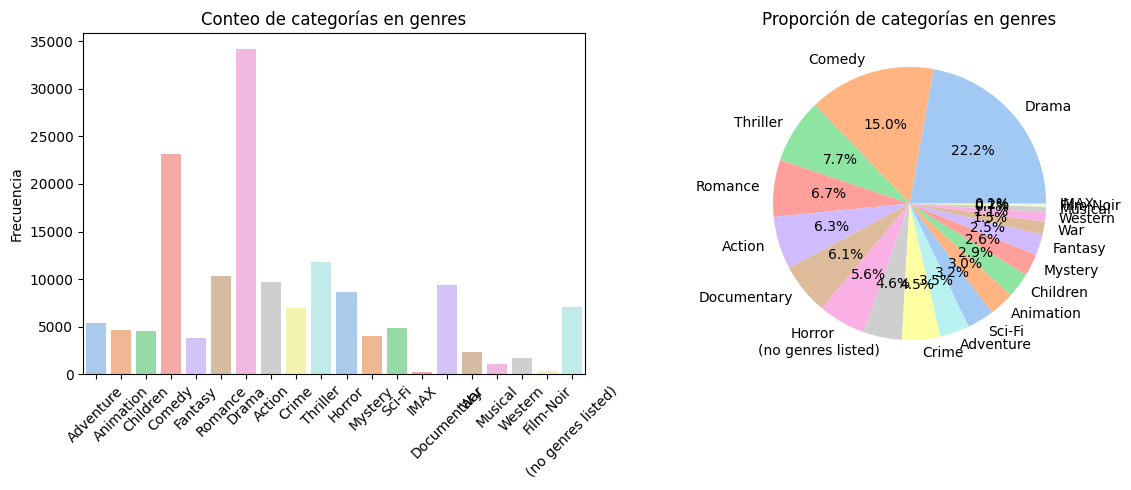

In [14]:
eda.plot_categorical_data(movie_genre)

In [15]:
eda.plot_categorical_data(movie_tag)

: 